In [3]:
import pickle 
import matplotlib.pyplot as plt
import numpy as np

In [4]:
log_paths = [
    "seed_1234_sample_rate_1_lr_0.1_n_epochs_300_hidden_dim_2_patience_100_log.pkl",
    "seed_1234_sample_rate_5_lr_0.1_n_epochs_300_hidden_dim_2_patience_100_log.pkl",
    "seed_1234_sample_rate_10_lr_0.1_n_epochs_300_hidden_dim_2_patience_100_log.pkl",
    "seed_1234_sample_rate_20_lr_0.1_n_epochs_300_hidden_dim_2_patience_100_log.pkl"
]

In [5]:
logs = []
for path in log_paths:
    with open(path,'rb') as file:
        logs.append(pickle.load(file))

max-epochs final loss 0.0094


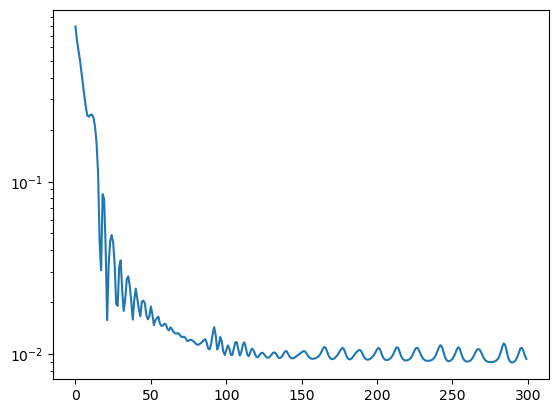

early-stoppage final loss 0.2544


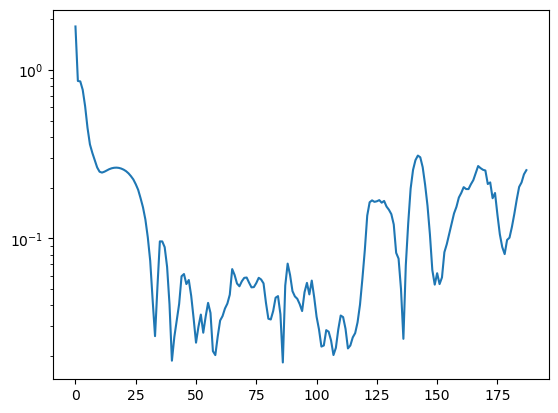

max-epochs final loss 0.0177


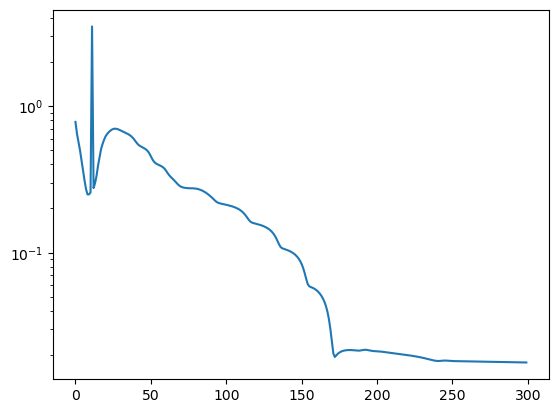

max-epochs final loss 0.0041


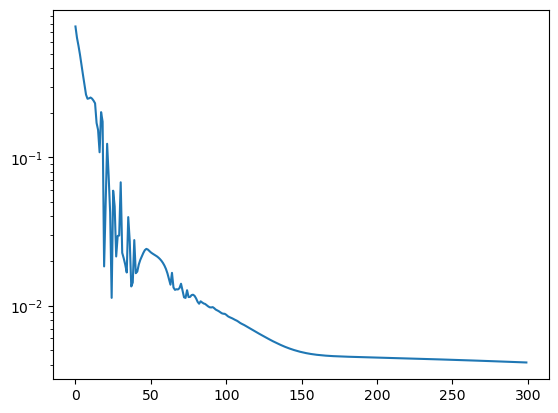

In [8]:
for log in logs:
    print(log["stopping_criteria"],  f"final loss {log['losses'][-1]:.4f}")
    plt.plot(log['losses'])
    plt.yscale('log')
    plt.show()

In [7]:
tot_times = []
for log in logs:
    tot_times.append(np.sum(log["times"]))

In [ ]:
np.array(tot_times)/60 /60

In [ ]:
logs[0].keys()

In [15]:
for log in logs:
    fails = log['method_failures']
    print(np.count_nonzero(fails))

0
0
299
300


# Losses on lr = 0.1 for simple hystersis example 

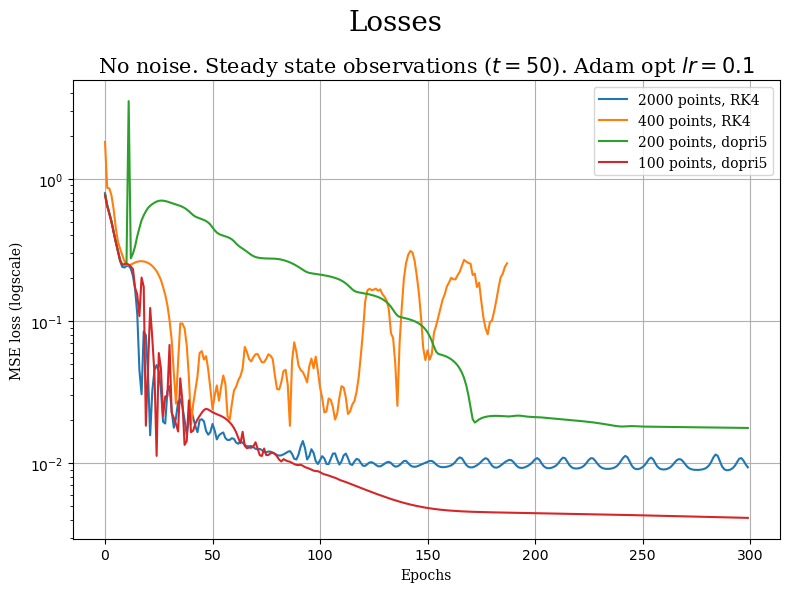

In [64]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
# plt.style.use('tableau-colorblind10')

family = 'serif'
labels = [
    f"{2000//1} points, RK4",
    f"{2000//5} points, RK4",
    f"{2000//10} points, dopri5",
    f"{2000//20} points, dopri5"
]

for label, log in zip(labels,logs):
    ax.plot(log["losses"], label=label)

ax.set_title(r"No noise. Steady state observations ($t=50$). Adam opt $lr = 0.1$", family=family, size=15)
ax.set_xlabel("Epochs", family=family)
ax.set_ylabel("MSE loss (logscale)", family=family)
plt.suptitle("Losses", family=family, size=20)
plt.legend(prop={'family': family})
plt.grid(True)
plt.yscale('log')
plt.tight_layout()
plt.savefig("losses_tanh_adam.png")
plt.show()

In [73]:
for log in logs:
    print(np.sum(log['times']) / 60 /60)

0.5373990545007917
0.06451827228069305
4.7158228875531085
5.709281213349766


# Compare model against data run in trial

In [74]:
from stabnode.node import set_global_seed, _load_model_opt
from data.hysteresis import simulate_steady_state
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

In [78]:
# Load data in the same way 
def load_data(seed, sample_rate):
    set_global_seed(seed = seed)
    
    lam_start = -1 
    lam_end = 1
    
    n_points = 250
    
    lam_increase = np.linspace(lam_start,lam_end, n_points)
    lam_decrease = np.linspace(lam_end, lam_start, n_points)
    
    x0=-1
    
    simulate_time = (0.,50.)
    
    x_increase = simulate_steady_state(lam_increase, x0, simulate_time,show_progress=True)
    x_decrease = simulate_steady_state(lam_decrease, x_increase[-1],simulate_time, show_progress=True)
    
    X = np.hstack((x_increase, x_decrease))
    lam = np.hstack((lam_increase, lam_decrease))
    repeat = 2
    
    for _ in range(repeat):
        X = np.hstack((X,X))
        lam = np.hstack((lam, lam))
    
    tau = torch.arange(0,len(lam),device=device)
    t = (tau+1)*simulate_time[-1]
    
    scaler = MinMaxScaler(feature_range=(-1,1))
    X_scaled = scaler.fit_transform(X.reshape(-1,1))
    X_scaled = torch.tensor(X_scaled,dtype=torch.float32, device=device)
    
    # sample_rate = 10
    tau_train = tau[::sample_rate]
    X_train = X_scaled[tau_train]
    lam_train = lam[tau_train]

    def lam_func(tau):
        idx = int(tau) % len(lam)
        return torch.tensor(lam[idx],dtype=torch.float32, device=device)
    
    return X, lam, tau, t, scaler, X_scaled, tau_train, X_train, lam_train, lam_func

In [82]:
model_paths = [
    "seed_1234_sample_rate_1_lr_0.1_n_epochs_300_hidden_dim_2_patience_100.pt",
    "seed_1234_sample_rate_5_lr_0.1_n_epochs_300_hidden_dim_2_patience_100.pt",
    "seed_1234_sample_rate_10_lr_0.1_n_epochs_300_hidden_dim_2_patience_100.pt",
    "seed_1234_sample_rate_20_lr_0.1_n_epochs_300_hidden_dim_2_patience_100.pt"
]

seeds = [1234,1234,1234,1234]
sample_rates = [1,5,10, 20]
lrs = [0.1,0.1, 0.1, 0.1]

In [83]:
def g_true(x,lam):
    return (1/x)*((lam / x)  + 1)

def f_true(x):
    return -x**2

In [84]:
def evaluate_model(model, X, lam, tau, t, scaler, X_scaled, tau_train, X_train, lam_train, lam_func):
    g = model.g
    f = model.f
    
    g.eval()
    f.eval()
    
    g_true_out = []
    g_pred_out = []
    
    f_true_out = []
    f_pred_out = []
    
    for tau_i in tau:
    
        lam_i = lam_func(tau_i).reshape(-1,1)
        xi = X_scaled[tau_i].reshape(-1,1)
        xi_unscaled = X[tau_i].reshape(-1,1)
    
        g_true_out.append(g_true(xi_unscaled,lam_i.numpy()))
        f_true_out.append(f_true(xi_unscaled))
    
        with torch.no_grad():
            g_pred_out.append(g(xi,lam_i).detach().cpu().numpy())
            f_pred_out.append(f(xi).detach().cpu().numpy())
    
    g_true_out = np.array(g_true_out).reshape(-1)
    g_pred_out = np.array(g_pred_out).reshape(-1)
    
    f_true_out = np.array(f_true_out).reshape(-1)
    f_pred_out = np.array(f_pred_out).reshape(-1)
    
    finite_idx = np.isfinite(g_true_out)
    np.count_nonzero(~finite_idx)
    g_true_scaled = scaler.transform(g_true_out[finite_idx].reshape(-1,1)).reshape(-1)
    
    L2_rel_err = np.linalg.norm(g_true_scaled - g_pred_out) / np.linalg.norm(g_true_scaled)

    return g_true_scaled, g_pred_out, tau_train, X_train, L2_rel_err

In [85]:
true = []
pred = []
tau = []
train = []
l2 = []

for path, seed, sample_rate in zip(model_paths,seeds, sample_rates):
    model, opt, epoch, loss = _load_model_opt(path)
    g_true_scaled, g_pred_out, tau_train, X_train, L2_rel_err= evaluate_model(model, *load_data(seed=seed,sample_rate=sample_rate))
    true.append(g_true_scaled)
    pred.append(g_pred_out)
    tau.append(tau_train)
    train.append(X_train)
    l2.append(L2_rel_err)
    

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [81]:
true

[array([-1.00030781, -0.99851447, -0.99701636, ..., -0.99768391,
        -0.9993466 , -1.00042778]),
 array([-1.00030781, -0.99851447, -0.99701636, ..., -0.99768391,
        -0.9993466 , -1.00042778]),
 array([-1.00030781, -0.99851447, -0.99701636, ..., -0.99768391,
        -0.9993466 , -1.00042778])]

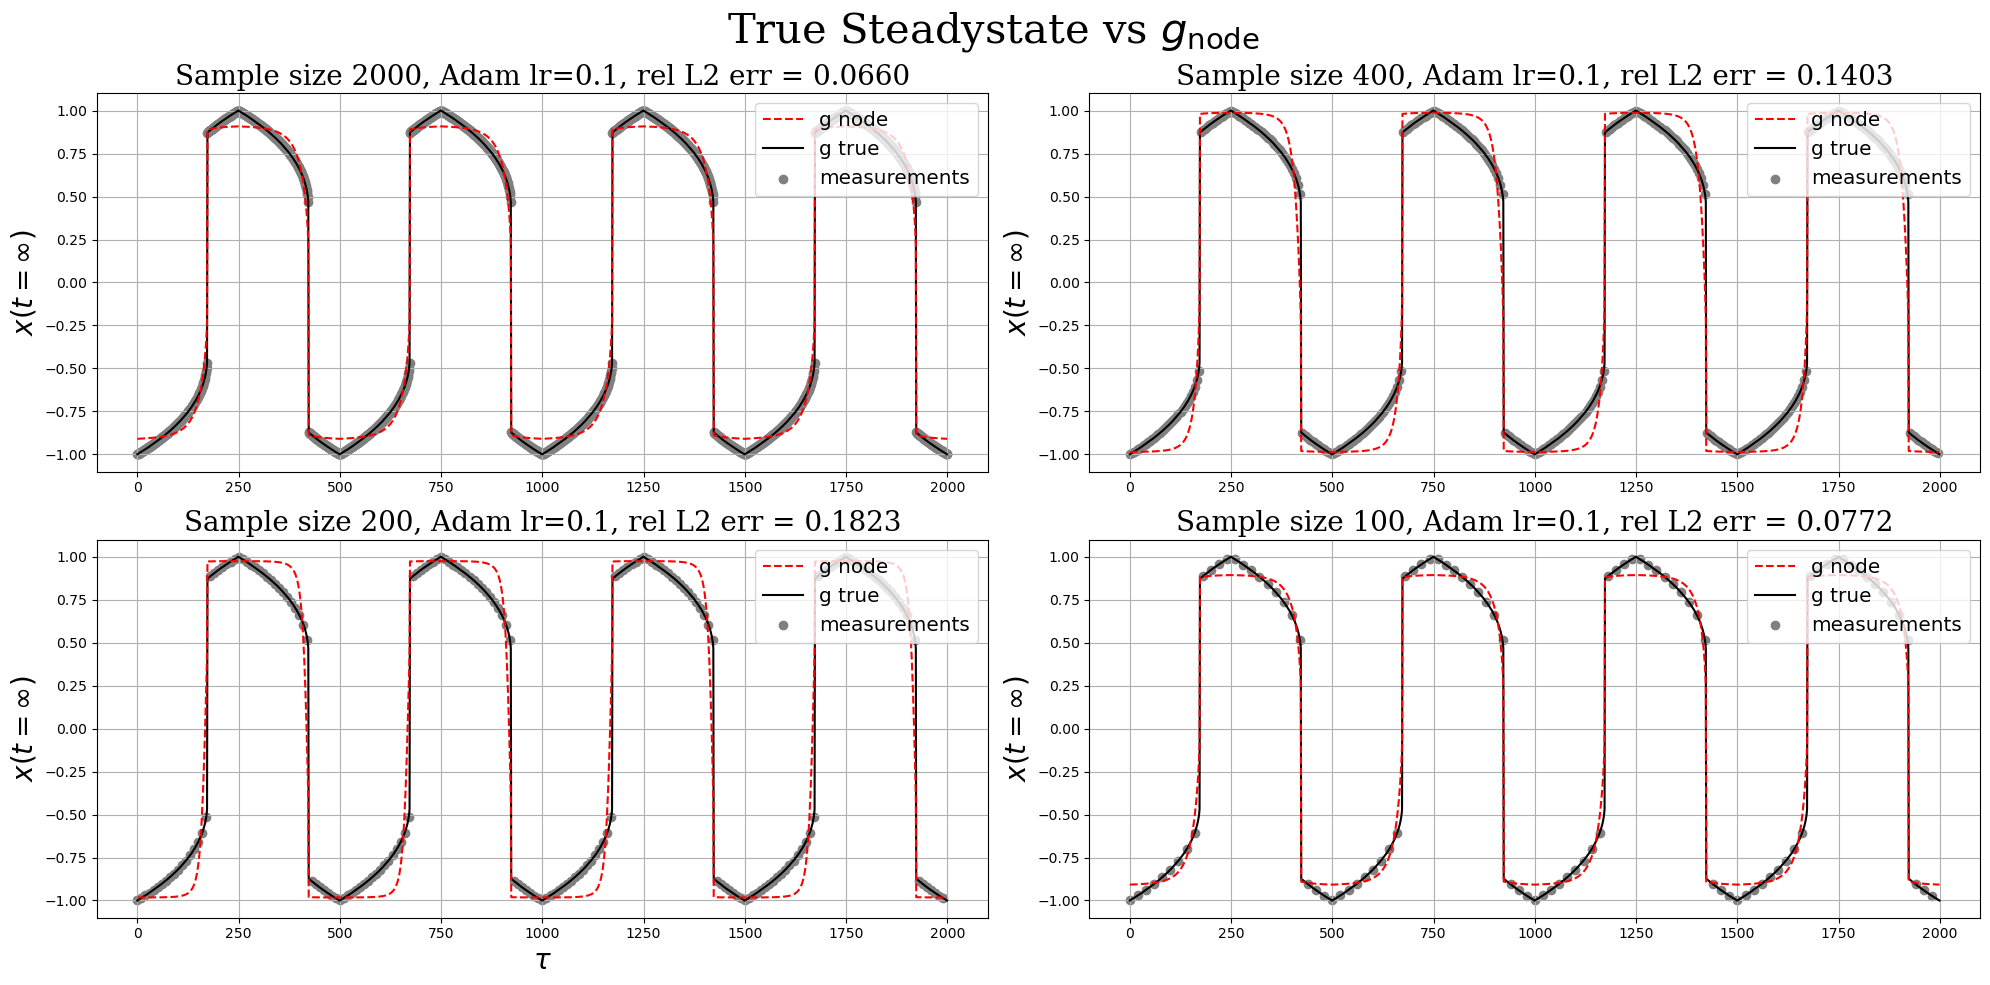

In [92]:

fig, ax  = plt.subplots(2,2,figsize = (20,10))
ax = ax.flatten()
for idx in range(4):
    ax[idx].plot(pred[idx], linestyle='--', c='red',label='g node', zorder = 5)
    ax[idx].plot(true[idx], label='g true', c='black')
    ax[idx].scatter(tau[idx], train[idx], c='grey', marker='o', label='measurements')
    # plt.plot(X_scaled, label='raw data')
    ax[idx].legend(loc='upper right',fontsize='x-large')
    ax[idx].grid(True)
    ax[idx].set_ylabel(r"$x(t=\infty)$",size=20)
    if idx == 2:
        ax[idx].set_xlabel(r"$\tau$", size=20)
    ax[idx].set_title(f"Sample size {2000//sample_rates[idx]}, Adam lr={lrs[idx]}, rel L2 err = {l2[idx]:.4f}", family='serif',size=20)
plt.suptitle(r"True Steadystate vs $g_{\text{node}}$ ",family='serif', size=30)
plt.tight_layout()
plt.savefig("steady_state_vs_gnode.png")
plt.show()

In [12]:
path = "seed_1234_sample_rate_40_lr_0.1_n_epochs_300_hidden_dim_2_patience_100_log.pkl"

In [13]:
import pickle 

In [14]:
with open(path,'rb') as file:
    log_hist = pickle.load(file)

In [15]:
log_hist.keys()

dict_keys(['losses', 'times', 'stopping_criteria', 'best_model_epoch', 'method_failures', 'patience_hist'])

In [16]:
log_hist['losses'], log_hist['stopping_criteria']

([0.750067949295044,
  0.6338071227073669,
  0.560655951499939,
  0.4874495565891266,
  0.4159485995769501,
  0.3582291305065155,
  0.3046550154685974,
  0.264372855424881,
  0.2501797378063202,
  0.2512746751308441,
  0.2531386613845825,
  0.2507047653198242,
  0.2410094141960144,
  0.23572668433189392,
  0.20336537063121796,
  0.1600068062543869,
  0.09314452856779099,
  0.013361829333007336,
  0.050179775804281235,
  0.1113300770521164,
  0.13116657733917236,
  0.19317856431007385,
  0.12842285633087158,
  0.08478938043117523,
  0.01629425585269928,
  0.030638933181762695,
  0.08453000336885452,
  0.07920152693986893,
  0.0692514032125473,
  0.02918688766658306,
  0.013015092350542545],
 'best-model-checkpoint')

In [17]:
log_hist["best_model_epoch"]

30